# Importing Libraries

In [1]:
from mimic.mimic import MIMIC, MIMICManipulations

In [2]:
from utils.util import generic_utils

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Load Data

In [4]:
df = pd.read_csv('./dataset/ch_03_dataset.csv')
df.head()

,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,hospital_expire_flag,los_admission,gender,...,flag,priority,drg_type,drg_code,drug,route,org_name,test_name,ab_name,curr_service
0,ELECTIVE,Other,HOME,Other,ENGLISH,Other,WHITE,0.0,1.968056,M,...,normal,STAT,HCFA,795.0,Other,IM,None,"Blood Culture, Routine",None,NB
1,EW EMER.,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,0.0,2.222222,F,...,abnormal,ROUTINE,HCFA,442.0,Influenza Vaccine Quadrivalent,IM,None,Other,None,MED
2,ELECTIVE,Other,HOME,Other,ENGLISH,Other,ASIAN,0.0,1.865278,F,...,normal,STAT,HCFA,795.0,Erythromycin 0.5% Ophth Oint,BOTH EYES,None,Other,None,NB
3,EU OBSERVATION,EMERGENCY ROOM,Other,Other,ENGLISH,SINGLE,WHITE,0.0,0.298611,F,...,normal,OTHER,OTHER,0.0,None,None,None,None,None,MED
4,ELECTIVE,Other,HOME,Other,ENGLISH,Other,WHITE,0.0,4.109722,M,...,normal,STAT,HCFA,795.0,Erythromycin 0.5% Ophth Oint,BOTH EYES,None,None,None,NB


## Select data to be used in classification

### For binary classification, use "flag" column and for multi-class classification, use "current service"

In [5]:
df.flag.value_counts()

normal      227037
abnormal     29759
Name: flag, dtype: int64

In [6]:
df.curr_service.value_counts()

MED      88405
NB       59972
SURG     17386
CMED     15344
ORTHO    13681
OBS      10748
NMED     10447
NSURG     7448
CSURG     5621
TRAUM     5071
OMED      4948
VSURG     3452
GYN       3336
PSYCH     2545
PSURG     2534
GU        2415
TSURG     2019
Other     1424
Name: curr_service, dtype: int64

In [7]:
# Set "flag" value to 1 (normal) or 0 (abnormal)
df.loc[df['flag'] == 'normal', 'flag'] = '1'
df.loc[df['flag'] == 'abnormal', 'flag'] = '0'
df.flag = df.flag.astype('int64')

In [8]:
# Get count of each class 
df.flag.value_counts()

1    227037
0     29759
Name: flag, dtype: int64

# Transformation Pipelines

In [9]:
# Convert data type to float64 or string
for column in df.columns:
    if column in ['hospital_expire_flag', 'los_admission', 'anchor_age', 'flag','drg_code']:
        try:
            df[column] = df[column].astype('float64')
        except Exception as ex:
            pass
    else:
        df[column] = df[column].astype('string')

In [10]:
df['flag'].astype('float64')

0         1.0
1         0.0
2         1.0
3         1.0
4         1.0
         ... 
256791    1.0
256792    1.0
256793    1.0
256794    1.0
256795    1.0
Name: flag, Length: 256796, dtype: float64

In [11]:
# Convert values to list
categorical_columns = df.select_dtypes(include=['string']).columns.tolist()
numerical_columns = df.select_dtypes(exclude=['string']).columns.tolist()[2:4] #keep columns 'anchor_age' and 'flag'

In [12]:
categorical_columns

['admission_type',
 'admission_location',
 'discharge_location',
 'insurance',
 'language',
 'marital_status',
 'ethnicity',
 'gender',
 'eventtype',
 'priority',
 'drg_type',
 'drug',
 'route',
 'org_name',
 'test_name',
 'ab_name',
 'curr_service']

In [13]:
numerical_columns

['anchor_age', 'flag']

In [14]:
# Remove "flag" column, which will be the labels for classification
numerical_columns.remove('flag')

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

In [16]:
# Define pipeline for numerical column transformation
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])

In [17]:
# Construct ColumnTransformer
num_attribs = numerical_columns
cat_attribs = categorical_columns

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OrdinalEncoder(), cat_attribs),
    ])

# Create Test Set

In [18]:
np.random.seed(42)

In [19]:
# Split data into training and testing set
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["flag"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [20]:
# Separate data from labels and define labels as "flag" value
train_set_X = strat_train_set.drop("flag", axis = 1)
train_set_y = strat_train_set["flag"]

test_set_X = strat_test_set.drop("flag", axis = 1)
test_set_y = strat_test_set["flag"]

In [21]:
# Transform training data using pipeline
train_set_X_prepared = full_pipeline.fit_transform(train_set_X)

In [22]:
train_set_X_prepared.shape

(205436, 18)

In [23]:
train_set_X_prepared

array([[ 0.39909861,  2.        ,  4.        , ...,  6.        ,
         4.        ,  4.        ],
       [-0.11151772,  7.        ,  4.        , ...,  9.        ,
         0.        ,  6.        ],
       [-1.43912018,  3.        ,  2.        , ...,  5.        ,
         4.        ,  5.        ],
       ...,
       [-1.43912018,  3.        ,  2.        , ...,  5.        ,
         4.        ,  5.        ],
       [ 0.50122187,  5.        ,  1.        , ...,  6.        ,
         4.        ,  0.        ],
       [ 1.35224909,  4.        ,  1.        , ...,  1.        ,
         4.        ,  4.        ]])

In [24]:
# Transform testing data using pipeline
X_test_prepared = full_pipeline.transform(test_set_X)

In [25]:
# Convert training labels to a NumPy array
train_set_y = train_set_y.to_numpy()
train_set_y

array([1., 1., 1., ..., 1., 1., 1.])

In [26]:
# Convert testing labels to a NumPy array
test_set_y = test_set_y.to_numpy()
test_set_y

array([1., 1., 1., ..., 1., 1., 1.])

# Training a Binary Classifier

In [27]:
# Fit a Stochastic Gradient Descent (SGD) classifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(train_set_X_prepared, train_set_y)

SGDClassifier(random_state=42)

In [28]:
# Use SGD to predict "flag" of a sample
sgd_clf.predict([train_set_X_prepared[2]])

array([1.])

# Performance Measures

## Measuring Accuracy Using Cross-Validation

In [29]:
# Get scores from running the SGD model with cross-validation using cross_val_score function
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, train_set_X_prepared, train_set_y, cv=3, scoring="accuracy")

array([0.88411046, 0.88411046, 0.88412337])

In [30]:
# For more control over the cross-validation process, implement cross-validation code step by step
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(train_set_X_prepared, train_set_y):
    clone_clf = clone(sgd_clf)
    X_train_folds = train_set_X_prepared[train_index]
    y_train_folds = train_set_y[train_index]
    X_test_fold = train_set_X_prepared[test_index]
    y_test_fold = train_set_y[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.8841104572204618
0.8841104572204618
0.8841233680890213


In [31]:
# Show that high accuracy may be due to imbalanced (skewed) datasets

# Set up a BaseEstimator that always predicts flag of '1.0' 
from sklearn.base import BaseEstimator

class Always1Classifier(BaseEstimator): 
    def fit(self,X,y=None):
        return self
    def predict(self,X):
        return np.ones(len(X))
    
always_1_clf = Always1Classifier()
cross_val_score(always_1_clf,train_set_X_prepared,train_set_y, cv=3, scoring = 'accuracy')

array([0.88411046, 0.88345332, 0.88478051])

## Confusion Matrix

In [32]:
# Get predictions (instead of scores above) for SGD model 
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, train_set_X_prepared, train_set_y, cv=3)

In [33]:
# Confusion matrix (row = true class, column = predicted class)
from sklearn.metrics import confusion_matrix

confusion_matrix(train_set_y, y_train_pred)

array([[     1,  23806],
       [     1, 181628]])

In our case, the first row is the class 'flag' = 0 and the second row is class 'flag' = 1. For both class, most of the samples were classified as 'flag' = 1 and only one sample was classified as 'flag' = 0. This suggests the model learned to classify almost everything as '1' due to the unbalanced dataset.

## Precision and Recall

In [34]:
# Compute precision metric
from sklearn.metrics import precision_score, recall_score

precision_score(train_set_y, y_train_pred, pos_label=1)

0.8841185003456098

In [35]:
# Check precision metric by calculating from confusion matrix
cm = confusion_matrix(train_set_y, y_train_pred)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8841185003456098

In [36]:
# Compute recall metric
recall_score(train_set_y, y_train_pred, pos_label=1)

0.9999944942712893

In [37]:
# Check recall metric by calculating from confusion matrix
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.9999944942712893

In [38]:
# Compute F1 score which combines precision and recall metrics
from sklearn.metrics import f1_score

f1_score(train_set_y, y_train_pred, pos_label=1)

0.938493216866505

In [39]:
# Check F1 score by calculating from confusion matrix
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.9384932168665049

## Precision/Recall Trade-off

In [40]:
# Get score used by SGD model to make prediction for a random sample
y_scores = sgd_clf.decision_function([train_set_X_prepared[546]])
y_scores

array([0.97163006])

In [41]:
# Set the threshold to 0 (what the SGD classifer uses) and get prediction
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [42]:
# Set the threshold to 8000 and get prediction
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [43]:
# Get all scores in training set
y_scores = cross_val_predict(sgd_clf, train_set_X_prepared, train_set_y, cv=3,
                             method="decision_function")

In [44]:
# Compute precision and recall for all possible thresholds
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(train_set_y, y_scores, pos_label=1)

In [45]:
recalls[np.argmax(precisions >= 0.90)]

0.2563797631435509

In [46]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    #plot specificiations (not shown in the HOML book)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([min(thresholds), max(thresholds), 0, 1])                                           

In [47]:
# Lowest recall that gives 90% precision
recall_90_precision = recalls[np.argmax(precisions >= 0.90)] 
recall_90_precision

0.2563797631435509

In [48]:
# Lowest threshold that gives 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

1.4165053991977394

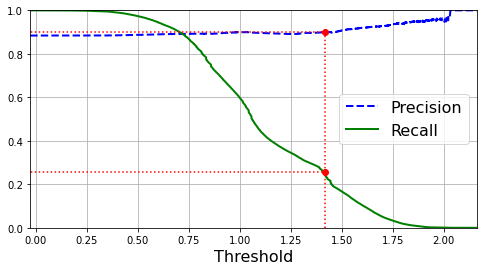

In [49]:
# Plot precision vs recall graph
plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
    
# Plot visual guide for 50% and 90% precision/recall (code not shown in book)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")               
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                               
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                            
plt.plot([threshold_90_precision], [recall_90_precision], "ro")    
                         
#save_fig("precision_recall_vs_threshold_plot")         

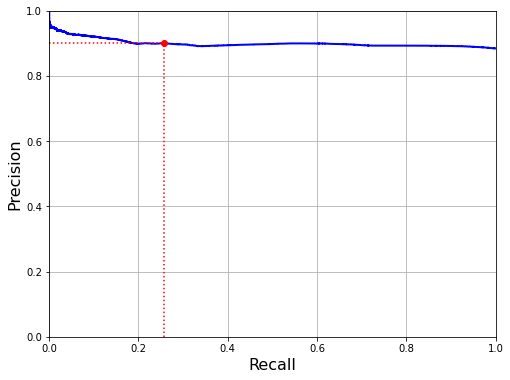

In [50]:
# Plot precision directly against recall
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
#save_fig("precision_vs_recall_plot")
plt.show()

In [51]:
(y_train_pred == (y_scores > 0))

array([ True,  True,  True, ...,  True,  True,  True])

In [52]:
# Make predictions based on minimum threshold that gives 90% precision
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90 = y_train_pred_90.astype('int')
# y_train_90 = []
# for item in y_train_pred_90:
#     if item == 1:
#         y_train_90.append(1)
#     elif item == 0:
#         y_train_90.append(0)

In [53]:
# Get precision
precision_score(train_set_y, y_train_pred_90, pos_label=1)

0.9

In [54]:
recall_score(train_set_y, y_train_pred_90, pos_label=1)

0.2563797631435509

## The ROC Curve

In [55]:
# Calculate false positive rates and true positive rates at different thresholds for SGD model
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(train_set_y, y_scores, pos_label=1)

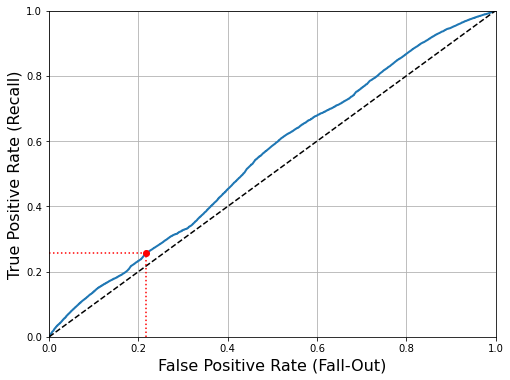

In [56]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #dashed diagonal
    #plot specificiations (not shown in the HOML book)
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                   
plot_roc_curve(fpr, tpr)

# Plot visual guide of TPR and FPR at 90% precision (code not shown in book)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)] #find fpr corresponding to lowest recall that gives 90% precision       
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:") 
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:") 
plt.plot([fpr_90], [recall_90_precision], "ro")           
#save_fig("roc_curve_plot")                               
plt.show()

In [57]:
# Calculate AUC for SGD model
from sklearn.metrics import roc_auc_score

roc_auc_score(train_set_y, y_scores)

0.5505729009055513

### Compare performance of SGD classifier with Random Forest classifier 

**Note**: we set `n_estimators=100` to be future-proof since this will be the default value in Scikit-Learn 0.22.

In [58]:
# Get class probabilities using Random Forest
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, train_set_X_prepared, train_set_y, cv=3,
                                    method="predict_proba")

In [59]:
# Use class probabilities to find FPR and TPR at different thresholds
y_scores_forest = y_probas_forest[:, 1] #score = probability of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(train_set_y,y_scores_forest, pos_label=1)

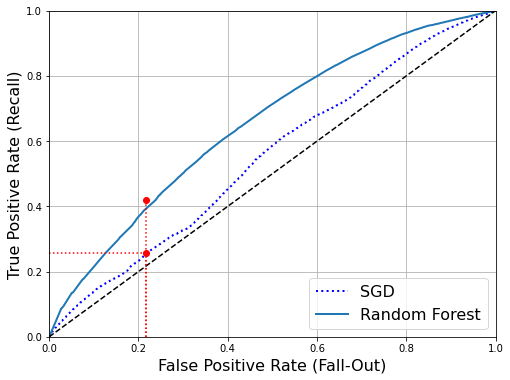

In [60]:
# Compare Random Forest classifier TPR to the SGD classifer's TPR at the SGD classifer's FPR at 90% precision 
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]


# Plot random forest ROC curve on top of SGD classifer's ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
#save_fig("roc_curve_comparison_plot")
plt.show()

In [61]:
# AUC score
roc_auc_score(train_set_y, y_scores_forest)

0.6513689581630975

In [62]:
# Make predictions and calculate precision
y_train_pred_forest = cross_val_predict(forest_clf, train_set_X_prepared, train_set_y, cv=3)
precision_score(train_set_y, y_train_pred_forest, pos_label=1)

0.8871488385658426

In [63]:
# Calculate rcall 
recall_score(train_set_y, y_train_pred_forest, pos_label=1)

0.9880800973412837

# Multiclass Classification

In [64]:
# Use LabelEncoder to converting 'curr_service' column to numerical values
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df.curr_service = le.fit_transform(df.curr_service)
df.head()

,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,hospital_expire_flag,los_admission,gender,...,flag,priority,drg_type,drg_code,drug,route,org_name,test_name,ab_name,curr_service
0,ELECTIVE,Other,HOME,Other,ENGLISH,Other,WHITE,0.0,1.968056,M,...,1.0,STAT,HCFA,795.0,Other,IM,None,"Blood Culture, Routine",None,5
1,EW EMER.,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,0.0,2.222222,F,...,0.0,ROUTINE,HCFA,442.0,Influenza Vaccine Quadrivalent,IM,None,Other,None,4
2,ELECTIVE,Other,HOME,Other,ENGLISH,Other,ASIAN,0.0,1.865278,F,...,1.0,STAT,HCFA,795.0,Erythromycin 0.5% Ophth Oint,BOTH EYES,None,Other,None,5
3,EU OBSERVATION,EMERGENCY ROOM,Other,Other,ENGLISH,SINGLE,WHITE,0.0,0.298611,F,...,1.0,OTHER,OTHER,0.0,None,None,None,None,None,4
4,ELECTIVE,Other,HOME,Other,ENGLISH,Other,WHITE,0.0,4.109722,M,...,1.0,STAT,HCFA,795.0,Erythromycin 0.5% Ophth Oint,BOTH EYES,None,None,None,5


In [65]:
df.curr_service.value_counts()

4     88405
5     59972
14    17386
0     15344
10    13681
8     10748
6     10447
7      7448
1      5621
15     5071
9      4948
17     3452
3      3336
13     2545
12     2534
2      2415
16     2019
11     1424
Name: curr_service, dtype: int64

In [66]:
categorical_columns = df.select_dtypes(include=['string']).columns.tolist()
categorical_columns

['admission_type',
 'admission_location',
 'discharge_location',
 'insurance',
 'language',
 'marital_status',
 'ethnicity',
 'gender',
 'eventtype',
 'priority',
 'drg_type',
 'drug',
 'route',
 'org_name',
 'test_name',
 'ab_name']

In [67]:
numerical_columns = df.select_dtypes(exclude=['string']).columns.tolist()[1:3]
numerical_columns

['los_admission', 'anchor_age']

In [68]:
# Run data through preprocessing pipeline 
num_attribs = numerical_columns
cat_attribs = categorical_columns

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OrdinalEncoder(), cat_attribs),
    ])

In [69]:
# Split into training and testing set
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["curr_service"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [70]:
# Separate features from labels
train_set_X = strat_train_set.drop("curr_service", axis = 1)
train_set_y = strat_train_set["curr_service"].to_numpy()

test_set_X = strat_test_set.drop("curr_service", axis = 1)
test_set_y = strat_test_set["curr_service"].to_numpy()

In [71]:
# Feed training and testing data through pipeline
train_set_X_prepared = full_pipeline.fit_transform(train_set_X)
test_set_X_prepared = full_pipeline.fit_transform(test_set_X)

In [72]:
# Use an SVM classifier with One vs. Rest (OvR) strategy
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

In [73]:
# Train classifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(train_set_X_prepared[:1000], train_set_y[:1000])

OneVsRestClassifier(estimator=SVC(gamma='auto', random_state=42))

In [74]:
# Make prediction for sample at a random index
ovr_clf.predict([train_set_X_prepared[52]])

array([0])

In [75]:
# Get the number of classifiers run using the OvR strategy (equal to number of output classes)
len(ovr_clf.estimators_)

18

In [76]:
# Train SGD model and make prediction for sample at random index
sgd_clf.fit(train_set_X_prepared, train_set_y)
sgd_clf.predict([train_set_X_prepared[52]])

array([4])

In [77]:
# See if the prediction is correct
train_set_y[52]

0

In [78]:
# Get the scores used by SGD classifier to make prediction on one sample
sgd_clf.decision_function([train_set_X_prepared[52]])

array([[ -1.29231241,  -1.98639279,  -1.96803049,  -1.84167022,
         -0.47202684, -20.01948937,  -0.83815541,  -1.44884151,
         -8.49072951,  -1.1501844 ,  -1.68792577,  -2.79300838,
         -1.57665861,  -4.35431812,  -1.4202394 ,  -1.5888321 ,
         -2.05043652,  -1.73817895]])

In [79]:
# Get accuracy of SGD classifier with 3-fold cross-validation
cross_val_score(sgd_clf, train_set_X_prepared, train_set_y, cv=3, scoring="accuracy")

array([0.57953533, 0.59190409, 0.47910278])

# Error Analysis

In [80]:
# Get predictions of SGD classifier and calculate confusion matrix
y_train_pred = cross_val_predict(sgd_clf, train_set_X_prepared, train_set_y, cv=3)
conf_mx = confusion_matrix(train_set_y, y_train_pred)
conf_mx

array([[   17,   471,   649,     5,  7611,     3,     1,  2395,    86,
            2,     1,     3,    31,     1,   569,   110,   315,     5],
       [    5,   844,   563,     0,  1356,     4,     0,  1151,    40,
            1,     6,     2,    20,     1,   311,    39,   151,     3],
       [    1,    69,   457,     2,   775,     0,     0,   338,    11,
            0,     1,     0,     8,     0,   120,    13,   137,     0],
       [    0,    43,   150,    14,  1115,    22,     1,   449,   126,
            0,     1,     0,    21,     1,   551,    57,   118,     0],
       [  104,  1133,  1648,    21, 54162,    74,     6,  8691,   879,
           25,     7,    33,   165,   127,  2046,   719,   881,     3],
       [    0,     0,     4,     0,     9, 47858,     0,    30,    29,
            0,     0,     6,     1,     7,     4,    25,     4,     0],
       [    3,   175,   357,     3,  5588,     9,     1,  1478,   162,
            4,     1,     4,    21,     8,   275,   163,   106,     0],

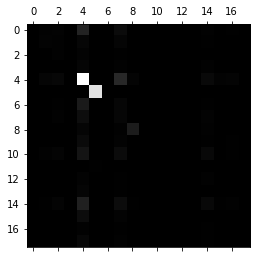

In [81]:
# Plot confusion matrix in grayscale with lighter colors representing higher values
plt.matshow(conf_mx,cmap=plt.cm.gray)
plt.show()

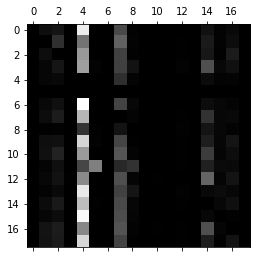

In [82]:
# Plot error rates in grayscale
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums #convert absolute error to error rate
np.fill_diagonal(norm_conf_mx,0) #fill diagonal with zeros 
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

In [83]:
from sklearn.metrics import ConfusionMatrixDisplay

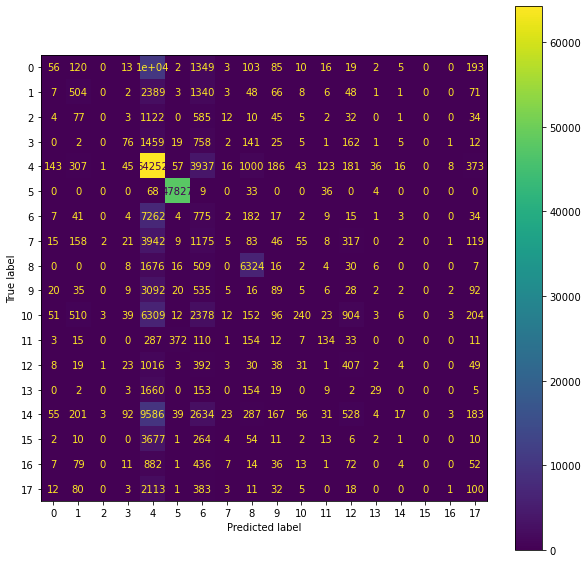

In [84]:
# Plot confusion matrix 
fig, ax = plt.subplots(figsize=(10,10))
conf_mx_plot = ConfusionMatrixDisplay.from_estimator(sgd_clf, train_set_X_prepared, train_set_y, ax=ax)

# Multilabel Multioutput Classification

### Use "flag" and "curr_service" as multilabel classes

In [85]:
df.flag = le.fit_transform(df.flag)

In [86]:
df.head()

,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,hospital_expire_flag,los_admission,gender,...,flag,priority,drg_type,drg_code,drug,route,org_name,test_name,ab_name,curr_service
0,ELECTIVE,Other,HOME,Other,ENGLISH,Other,WHITE,0.0,1.968056,M,...,1,STAT,HCFA,795.0,Other,IM,None,"Blood Culture, Routine",None,5
1,EW EMER.,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,0.0,2.222222,F,...,0,ROUTINE,HCFA,442.0,Influenza Vaccine Quadrivalent,IM,None,Other,None,4
2,ELECTIVE,Other,HOME,Other,ENGLISH,Other,ASIAN,0.0,1.865278,F,...,1,STAT,HCFA,795.0,Erythromycin 0.5% Ophth Oint,BOTH EYES,None,Other,None,5
3,EU OBSERVATION,EMERGENCY ROOM,Other,Other,ENGLISH,SINGLE,WHITE,0.0,0.298611,F,...,1,OTHER,OTHER,0.0,None,None,None,None,None,4
4,ELECTIVE,Other,HOME,Other,ENGLISH,Other,WHITE,0.0,4.109722,M,...,1,STAT,HCFA,795.0,Erythromycin 0.5% Ophth Oint,BOTH EYES,None,None,None,5


In [87]:
# Display categorical features
categorical_columns = df.select_dtypes(include=['string']).columns.tolist()
categorical_columns

['admission_type',
 'admission_location',
 'discharge_location',
 'insurance',
 'language',
 'marital_status',
 'ethnicity',
 'gender',
 'eventtype',
 'priority',
 'drg_type',
 'drug',
 'route',
 'org_name',
 'test_name',
 'ab_name']

In [88]:
# Display numerical features
numerical_columns = df.select_dtypes(exclude=['string']).columns.tolist()[1:3]
numerical_columns

['los_admission', 'anchor_age']

In [89]:
# Pass data through pipeline
num_attribs = numerical_columns
cat_attribs = categorical_columns

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OrdinalEncoder(), cat_attribs),
    ])

In [90]:
# Split training and testing data
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df[["flag","curr_service"]]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [91]:
# Separate features and labels
train_set_X = strat_train_set.drop(["flag", "curr_service"], axis = 1)
train_set_y = strat_train_set[["flag", "curr_service"]].to_numpy()

test_set_X = strat_test_set.drop(["flag", "curr_service"], axis = 1)
test_set_y = strat_test_set[["flag", "curr_service"]].to_numpy()

In [92]:
# Pass training and testing data through pipeline
train_set_X_prepared = full_pipeline.fit_transform(train_set_X)
test_set_X_prepared = full_pipeline.fit_transform(test_set_X)

In [93]:
train_set_y

array([[ 0,  4],
       [ 1,  9],
       [ 1,  4],
       ...,
       [ 1,  5],
       [ 1, 14],
       [ 1,  4]])

In [94]:
# Fit KNN Classifier to training data
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(train_set_X_prepared, train_set_y)

KNeighborsClassifier()

In [95]:
# Make prediction for single sample
knn_clf.predict([train_set_X_prepared[52]])

array([[1, 5]])

In [96]:
# Get predictions from KNN with 3-fold cross-validation
y_train_knn_pred = cross_val_predict(knn_clf, train_set_X_prepared, train_set_y, cv=3)

In [97]:
# Print predictions
y_train_knn_pred

array([[1, 4],
       [1, 4],
       [1, 4],
       ...,
       [0, 5],
       [1, 4],
       [1, 4]])

In [99]:
# Print training labels
train_set_y

array([[ 0,  4],
       [ 1,  9],
       [ 1,  4],
       ...,
       [ 1,  5],
       [ 1, 14],
       [ 1,  4]])